In [131]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [348]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE,
  CC_DAYS_TO_ADD,
  TERMS_OF_PAYMENT_KEY  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
    AND ("2024-01-01" >=PAYMENT_DATE)
ORDER BY
  PAYMENT_DATE
"""

In [349]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [350]:
df

,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,TERMS_OF_PAYMENT_KEY
0,0011120472,,,,None,2021-01-01,DH,15 - Incoming payment,-25.200000000,Z2140,CLEAR,2021-01-01,0E-9,
1,0011193210,,,,None,2021-01-01,DH,15 - Incoming payment,-498.440000000,Z2140,CLEAR,2021-01-01,0E-9,
2,0011193216,7100000246,7100000246 - HCA,,None,2021-01-01,DH,15 - Incoming payment,-1191.450000000,Z2140,CLEAR,2021-01-01,0E-9,
3,0010023713,7100000246,7100000246 - HCA,,None,2021-01-01,DH,15 - Incoming payment,-546.160000000,Z2140,CLEAR,2021-01-01,0E-9,
4,0010021326,7100000246,7100000246 - HCA,,None,2021-01-01,DH,15 - Incoming payment,-5726.100000000,Z2140,CLEAR,2021-01-01,0E-9,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259368,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2023-12-22,DH,07 - Other clearing,14319.260000000,Z2140,CLEAR,2023-12-22,0E-9,Y020
2259369,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2022-03-31,DH,16 - Payment difference,-6.390000000,Z2140,CLEAR,2023-12-22,0E-9,
2259370,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2023-12-22,DH,07 - Other clearing,66252.190000000,Z2140,CLEAR,2023-12-22,0E-9,Y020
2259371,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2022-08-09,DH,16 - Payment difference,-4.330000000,Z2140,CLEAR,2023-12-22,0E-9,


# Step 1
- ### Search by:
    - CUSTOMER_NUMBER
    - ENTERPRISE_ACCOUNT_NO
    

## Search by CUSTOMER_NUMBER
customer = "2057194397"

## Final Product
**Year Month CREDIT_CONTROL_AREA CC_DAYS_TO_ADD WAPD**

0	2022	Dec 	PD	 28.0000	                     30.0434

1	2022	Nov 	PD	 28.0000	                     29.9682

2	2022	Oct 	PD	 28.0000  	                 29.9637

3	2022	Sep 	PD	 28.0000	                     29.9744

4	2023	Apr 	PD	 28.0000	                     24.8993

5	2023	Aug 	PD	 28.0000	                     26.6483

6	2023	Feb 	PD	 28.0000	                     28.5953

7	2023	Jan 	PD	 28.0000	                     29.7159

8	2023	Jul 	PD	 28.0000	                     25.0257

9	2023	Jun 	PD	 28.0000	                     25.7423

10	2023	Mar 	PD	 28.0000	                     25.1921

11	2023	May 	PD	 28.0000	                     24.3104

12	2023	Sep 	PD	 28.0000	                     27.9685


# Step 2:
- Create new columns
    - Sub Payment Date from Invoice Date
    - Weighted Invoice Value
    - WAPD

In [858]:
# KEEEEEEP

query = """
SELECT
  customer_number,
  payment_month,
  AVG(Three_MONTH_AVG_WAPD) AS WAPD,
  total_WEIGHTED_INV_VALUE,
  total_INVOICE_VALUE,
  MIN(total_WEIGHTED_INV_VALUE)/MIN(total_INVOICE_VALUE) AS OVERALL_WAPD,
  
FROM (
  SELECT
    Customer_Number,
    Payment_Month,
    CREDIT_CONTROL_AREA,
    TERMS_OF_PAYMENT_KEY,
    SUM(SUM(weighted_Invoice_Value)) OVER(PARTITION BY CUSTOMER_NUMBER ) as total_WEIGHTED_INV_VALUE,
    SUM(SUM(AMOUNT_IN_LOCAL_CURRENCY)) OVER(PARTITION BY CUSTOMER_NUMBER ) AS total_INVOICE_VALUE,

     

    CASE
      WHEN (END_DATE BETWEEN START_DATE AND END_DATE) THEN ROUND(((SUM(weighted_Invoice_Value))/(SUM(AMOUNT_IN_LOCAL_CURRENCY))),2)
    ELSE
    (CAST ('0' AS int))
  END
    Three_MONTH_AVG_WAPD
  FROM (
    SELECT
      CUSTOMER_NUMBER,
      DATE_TRUNC(PAYMENT_DATE, MONTH) AS Payment_month,
      Payment_date AS END_DATE,
      ninty_days_ago AS START_DATE,
      CREDIT_CONTROL_AREA,
      TERMS_OF_PAYMENT_KEY,
      AMOUNT_IN_LOCAL_CURRENCY,
      weighted_Invoice_Value,
      --AVG(AMOUNT_IN_LOCAL_CURRENCY) AS INVOICE_VALUE,
      --AVG(weighted_Invoice_Value) AS WEIGHTED_INV_VALUE,
       /*CASE
    WHEN ( PAYMENT_DATE BETWEEN PAYMENT_DATE AND ninty_days_ago) THEN (SUM(weighted_Invoice_Value)/SUM(AMOUNT_IN_LOCAL_CURRENCY) )
  ELSE
  (CAST('0' AS int) )
END
  WAPD*/
FROM (
  SELECT
    CUSTOMER_NUMBER,
    ENTERPRISE_ACCOUNT_NO ENTERPRISE_ACCOUNT_NAME,
    NATIONAL_ACCOUNT,
    PAYER,
    DOCUMENT_DATE_IN_DOCUMENT,
    ACCOUNTING_DOCUMENT_NUMBER,
    ACCOUNTING_DOCUMENT_LINE_ITEM,
    POSTING_DATE_IN_DOCUMENT,
    DOCUMENT_TYPE,
    DOCUMENT_YEAR,
    DOCUMENT_MONTH,
    POSTING_KEY_NAME,
    AMOUNT_IN_LOCAL_CURRENCY,
    CREDIT_CONTROL_AREA,
    AR_STATUS,
    PAYMENT_DATE,
    CC_DAYS_TO_ADD,
    TERMS_OF_PAYMENT_KEY,
    DATE_DIFF(CAST(PAYMENT_DATE AS DATE), CAST(DOCUMENT_DATE_IN_DOCUMENT AS DATE), DAY) AS Open_Days,
    DATE_DIFF(CAST(PAYMENT_DATE AS DATE), CAST(DOCUMENT_DATE_IN_DOCUMENT AS DATE), DAY) * AMOUNT_IN_LOCAL_CURRENCY AS weighted_Invoice_Value,
    (CAST(PAYMENT_DATE AS DATE)-90) AS ninty_days_ago
  FROM
    `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
  WHERE
    POSTING_KEY = '01'
    AND ("2024-01-01" >=PAYMENT_DATE)
    AND CUSTOMER_NUMBER = "2057194397"
    AND PAYMENT_DATE IS NOT NULL
    AND DOCUMENT_DATE_IN_DOCUMENT IS NOT NULL
    AND AR_STATUS = "CLEAR"
  GROUP BY
    CUSTOMER_NUMBER,
    ENTERPRISE_ACCOUNT_NO,
    ENTERPRISE_ACCOUNT_NAME,
    NATIONAL_ACCOUNT,
    PAYER,
    DOCUMENT_DATE_IN_DOCUMENT,
    ACCOUNTING_DOCUMENT_NUMBER,
    ACCOUNTING_DOCUMENT_LINE_ITEM,
    POSTING_DATE_IN_DOCUMENT,
    DOCUMENT_TYPE,
    POSTING_KEY_NAME,
    AMOUNT_IN_LOCAL_CURRENCY,
    CREDIT_CONTROL_AREA,
    AR_STATUS,
    PAYMENT_DATE,
    CC_DAYS_TO_ADD,
    DOCUMENT_YEAR,
    DOCUMENT_MONTH,
    TERMS_OF_PAYMENT_KEY
  ORDER BY
    PAYMENT_DATE)
GROUP BY
  CUSTOMER_NUMBER,
  Document_month,
  Payment_date,
  DATE_TRUNC(PAYMENT_DATE, MONTH),
  ninty_days_ago,
  Payment_date,
  CREDIT_CONTROL_AREA,
  TERMS_OF_PAYMENT_KEY,AMOUNT_IN_LOCAL_CURRENCY,
      weighted_Invoice_Value
ORDER BY
  Document_month DESC )
WHERE
  Payment_month >= Payment_month-3
GROUP BY
  Customer_Number,
  Payment_Month,
  END_DATE,
  START_DATE,
  CREDIT_CONTROL_AREA,
  TERMS_OF_PAYMENT_KEY
  --,weighted_Invoice_Value,AMOUNT_IN_LOCAL_CURRENCY 
ORDER BY
  Payment_month)
GROUP BY
  Payment_month,
  customer_number,total_WEIGHTED_INV_VALUE ,total_INVOICE_VALUE 
ORDER BY 
Payment_month"""

In [859]:
bqclient = bigquery.Client()
df_customer_Crystal= bqclient.query(query).to_dataframe()

In [860]:
df_customer_Crystal

,customer_number,payment_month,WAPD,total_WEIGHTED_INV_VALUE,total_INVOICE_VALUE,OVERALL_WAPD
0,2057194397,2022-09-01,30.096000000,34107240.420000000,1251695.210000000,27.248838333
1,2057194397,2022-10-01,29.820000000,34107240.420000000,1251695.210000000,27.248838333
2,2057194397,2022-11-01,29.586000000,34107240.420000000,1251695.210000000,27.248838333
3,2057194397,2022-12-01,30.384000000,34107240.420000000,1251695.210000000,27.248838333
4,2057194397,2023-01-01,28.970000000,34107240.420000000,1251695.210000000,27.248838333
5,2057194397,2023-02-01,28.670000000,34107240.420000000,1251695.210000000,27.248838333
6,2057194397,2023-03-01,22.320000000,34107240.420000000,1251695.210000000,27.248838333
7,2057194397,2023-04-01,25.514285714,34107240.420000000,1251695.210000000,27.248838333
8,2057194397,2023-05-01,26.605000000,34107240.420000000,1251695.210000000,27.248838333
9,2057194397,2023-06-01,24.887500000,34107240.420000000,1251695.210000000,27.248838333


In [134]:
df_customer_Crystal['Payment_Month']=pd.to_datetime(df_customer_Crystal['Payment_Month'])
df_customer_Crystal['Payment_Month'].dt.strftime('%b')

0     Sep
1     Sep
2     Sep
3     Sep
4     Sep
     ... 
57    Aug
58    Sep
59    Sep
60    Sep
61    Sep
Name: Payment_Month, Length: 62, dtype: object

In [135]:
def final_dataFram(toFix_df):
    toFix_df['month'] = toFix_df['Payment_Month'].dt.strftime('%b')
    toFix_df['year'] = toFix_df['Payment_Month'].dt.strftime('%Y')
    df_final = pd.DataFrame({'Year': toFix_df.year,
                   'Month': toFix_df.month,
                   'CREDIT_CONTROL_AREA': toFix_df.CREDIT_CONTROL_AREA,
                   'WAPD':toFix_df.Three_MONTH_AVG_WAPD,
                    "TERMS_OF_PAYMENT_KEY":toFix_df.TERMS_OF_PAYMENT_KEY})
    dfff = (
        df_final
        .filter(["Year", "Month","CREDIT_CONTROL_AREA","WAPD","TERMS_OF_PAYMENT_KEY"])
        .groupby(['Year','Month','CREDIT_CONTROL_AREA',"TERMS_OF_PAYMENT_KEY"])
        .agg({'WAPD' : ['mean']})
        .sort_values(['Year',"Month","TERMS_OF_PAYMENT_KEY"])
        .reset_index()
    )
    dfff.columns = ['Year','Month', 'CREDIT_CONTROL_AREA','TERMS_OF_PAYMENT_KEY',"WAPD"]
    get_graph(dfff)
    return dfff.head(65)

In [136]:
def get_graph(finished_df):
    dff = pd.DataFrame(
        dict(
            year=finished_df.Year.values ,
            month=finished_df.Month.values,
            CCA= finished_df.CREDIT_CONTROL_AREA.values,
            WAPD=finished_df.WAPD.values,
            dso_term = int(finished_df.TERMS_OF_PAYMENT_KEY.values[0][2:4])
        )
    )

    fig = go.Figure()
    # fig = make_subplots(1,1)

    fig.update_layout(
        template="none",
        xaxis=dict(title_text="Year"),
        yaxis=dict(title_text="WAPD"),
        barmode="group",
    )

    colors = ["#456e73","#2A66DE", "#FFC32B","#457353"]

    for r, c in zip(dff.CCA.unique(), colors):
        plot_df = dff[dff.CCA == r]
        fig.add_trace(go.Bar(x=[plot_df.year, plot_df.month], y=plot_df.WAPD, name=r, marker_color=c))


    fig.add_trace(go.Scatter(x= [dff.year, dff.month], y=dff.dso_term, mode = 'lines',name = "DSO Term"))


    # fig.plot(fi.CC_DAYS_TO_ADD, c = "y", label = "DSO Term",zorder=10)
    fig.update_layout(title='WAPD')
    fig.show()

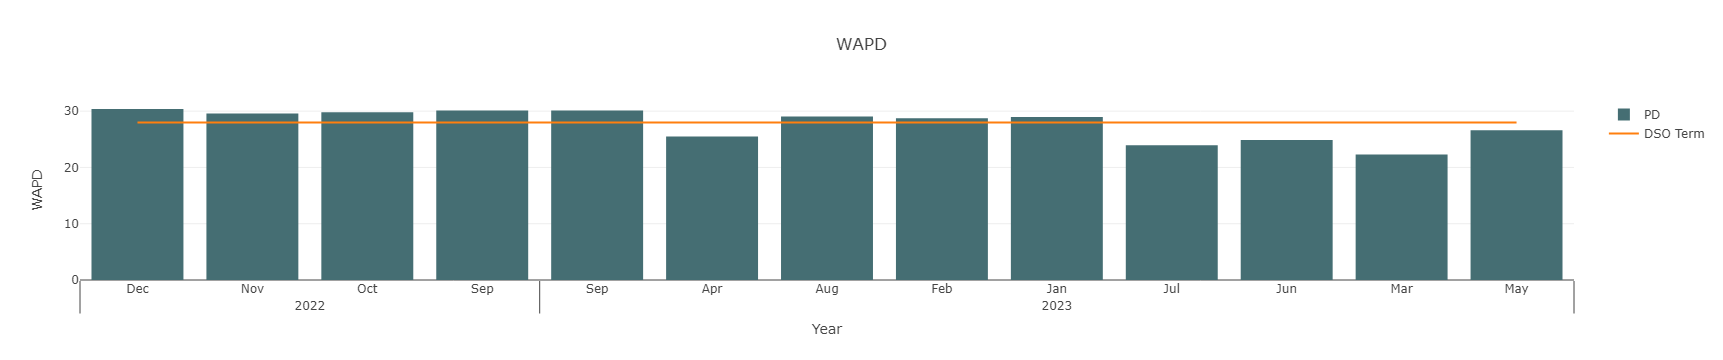

,Year,Month,CREDIT_CONTROL_AREA,TERMS_OF_PAYMENT_KEY,WAPD
0,2022,Dec,PD,YS28,30.384000
1,2022,Nov,PD,YS28,29.586000
2,2022,Oct,PD,YS28,29.820000
3,2022,Sep,PD,YS28,30.096000
4,2023,Apr,PD,YS28,25.514286
5,2023,Aug,PD,YS28,29.070000
6,2023,Feb,PD,YS28,28.720000
7,2023,Jan,PD,YS28,28.970000
8,2023,Jul,PD,YS28,23.932500
9,2023,Jun,PD,YS28,24.887500


In [137]:
final_dataFram(df_customer_Crystal)

In [219]:
df_customer_Crystal.WAPD.mean()

27.461305584290322